In [1]:
#import the necessary libraries
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import seaborn as sns
from time import perf_counter
import shutil
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve

In [2]:
#distribution of dataset
import os

def count_images_in_folder(folder_path):
    # List of common image file extensions
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'}
    
    # Initialize image count
    image_count = 0
    
    # Traverse through the directory
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            # Check if the file has an image extension
            if os.path.splitext(file)[1].lower() in image_extensions:
                image_count += 1
    
    return image_count

# Call the function to get the number of images
no_dr_images = count_images_in_folder('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/No_DR')
print(f"Number of images in the No_DR folder: {no_dr_images}")

mild_images = count_images_in_folder('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild')
print(f"Number of images in the Mild folder: {mild_images}")

moderate_images = count_images_in_folder('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Moderate')
print(f"Number of images in the Moderate folder: {moderate_images}")

severe_images = count_images_in_folder('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Severe')
print(f"Number of images in the Severe folder: {severe_images}")

proliferate_images = count_images_in_folder('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR')
print(f"Number of images in the Proliferate folder: {proliferate_images}")

Number of images in the No_DR folder: 1805
Number of images in the Mild folder: 370
Number of images in the Moderate folder: 999
Number of images in the Severe folder: 193
Number of images in the Proliferate folder: 295


In [3]:
#defining the paths and corresponding labels
image_dir = Path('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered')
# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [4]:
#image dataset
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

Filepath     Label
0  /kaggle/input/diabetic-retinopathy-224x224-gau...     No_DR
1  /kaggle/input/diabetic-retinopathy-224x224-gau...     No_DR
2  /kaggle/input/diabetic-retinopathy-224x224-gau...  Moderate

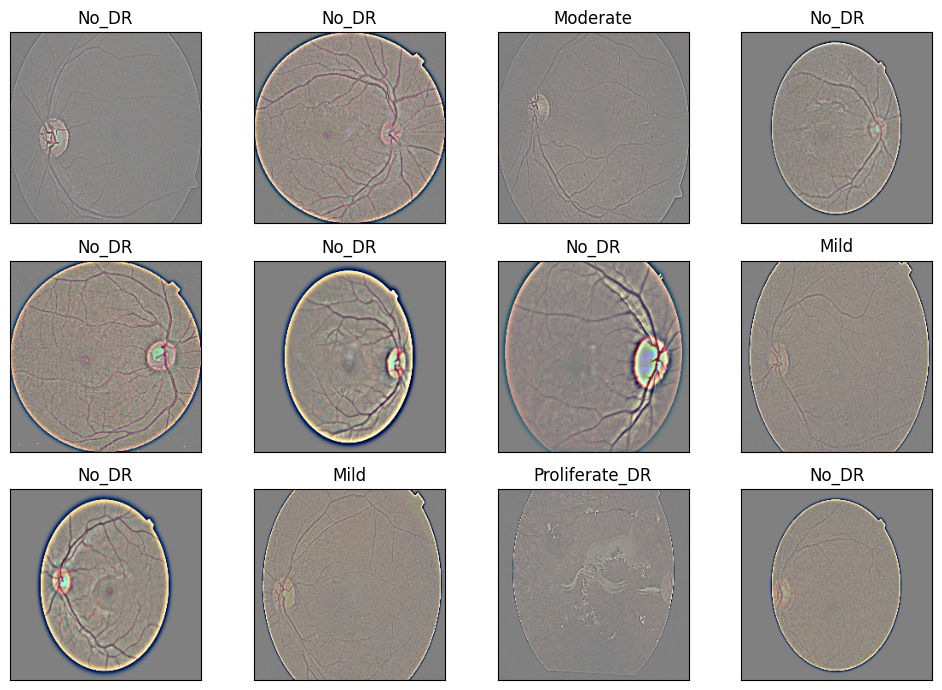

In [5]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

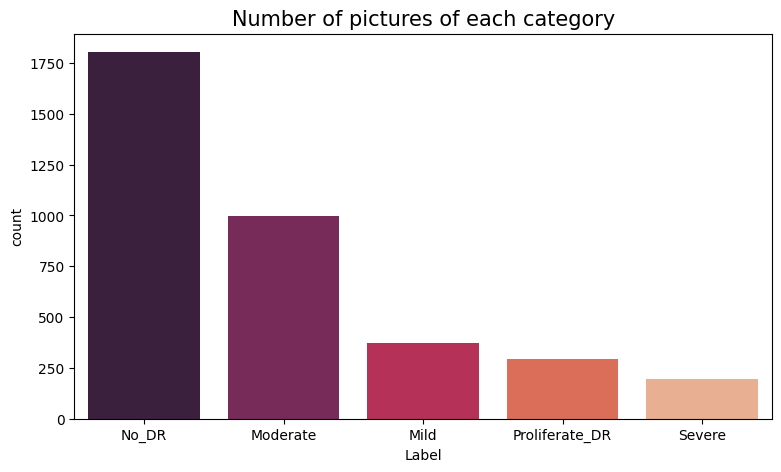

In [6]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [7]:
# Load the Images with a generator and Data Augmentation
def create_gen():
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [8]:
#Load all the pretrained models
def get_model(model):
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(1024, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dropout(0.5)(x)  # Dropout layer to reduce overfitting
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)  # Another dropout for regularization
    
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [9]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.8, shuffle=True, random_state=1,  stratify=labels)

In [10]:
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

Found 2637 validated image filenames belonging to 5 classes.
Found 292 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.




In [11]:
# Dictionary with the models
models = {
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB5": {"model":tf.keras.applications.EfficientNetB5, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

# Fit the models
for name, model in models.items():
    
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=5,verbose=1)
    
    # Sav the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]
    
    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1740674848.035069      71 service.cc:145] XLA service 0x7b4258003e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740674848.035125      71 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1740674848.035131      71 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/83 ━━━━━━━━━━━━━━━━━━━━ 54:00 40s/step - accuracy: 0.1250 - loss: 2.2106

I0000 00:00:1740674869.782899      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


83/83 ━━━━━━━━━━━━━━━━━━━━ 100s 734ms/step - accuracy: 0.6125 - loss: 1.2140 - val_accuracy: 0.7534 - val_loss: 0.6993
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.7413 - loss: 0.7132 - val_accuracy: 0.7842 - val_loss: 0.6508
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.7503 - loss: 0.6742 - val_accuracy: 0.7945 - val_loss: 0.6311
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.7636 - loss: 0.6511 - val_accuracy: 0.7911 - val_loss: 0.6223
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.7595 - loss: 0.6552 - val_accuracy: 0.7637 - val_loss: 0.6369
DenseNet169          trained in 139.62 sec
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 84s 591ms/step - accuracy: 0.5873 - loss: 1.3275 - val_accuracy: 0.7740 - val_loss: 0.7214
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 0.7146 - loss: 0.7486 - val_accuracy: 0.7877 - val_loss: 0.6263
Epoch 3/5
83/83 ━━━

In [12]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, 
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])

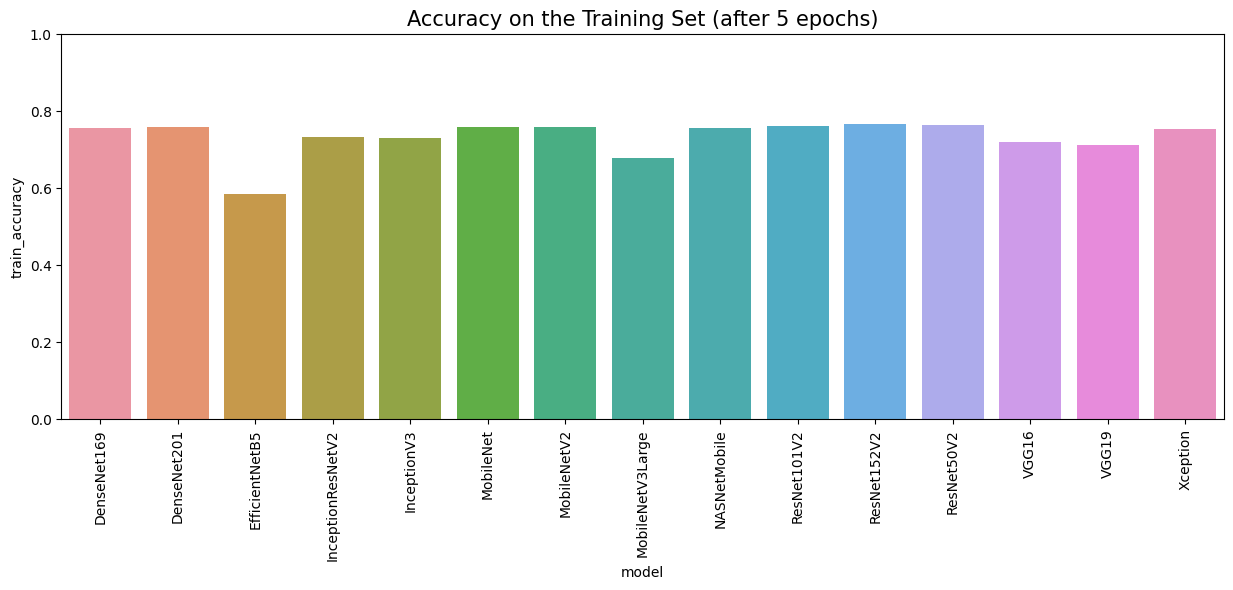

In [13]:
#training accuracy of different pretrained models
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'train_accuracy', data = df_results)
plt.title('Accuracy on the Training Set (after 5 epochs)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

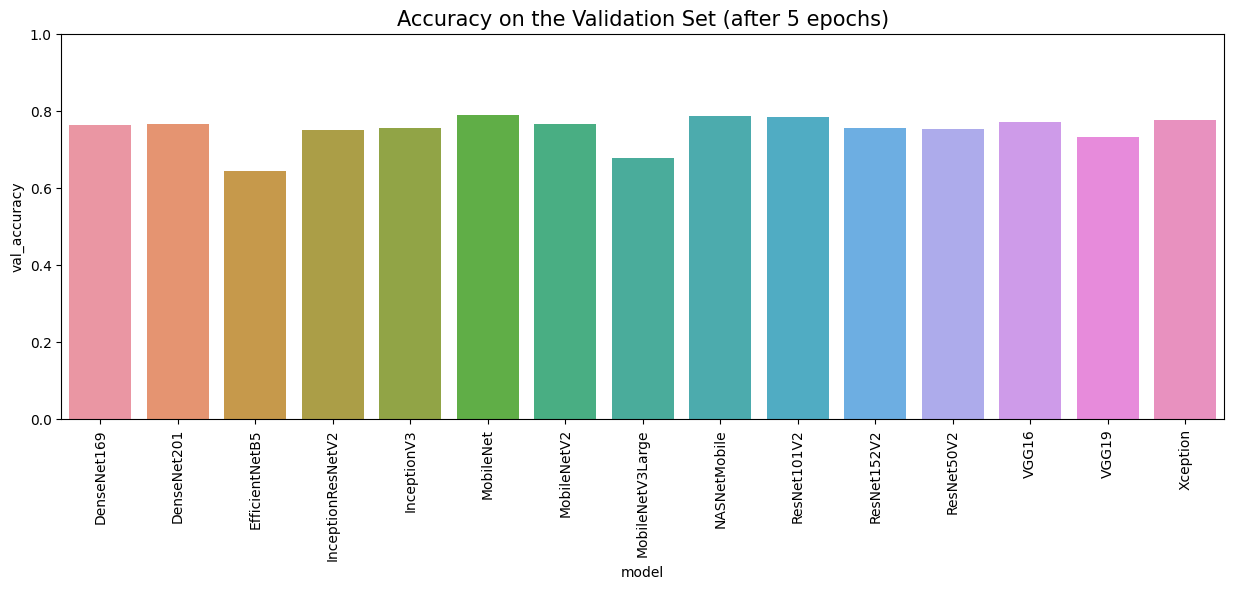

In [14]:
#validation accuracy of different pretrained models
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_results)
plt.title('Accuracy on the Validation Set (after 5 epochs)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

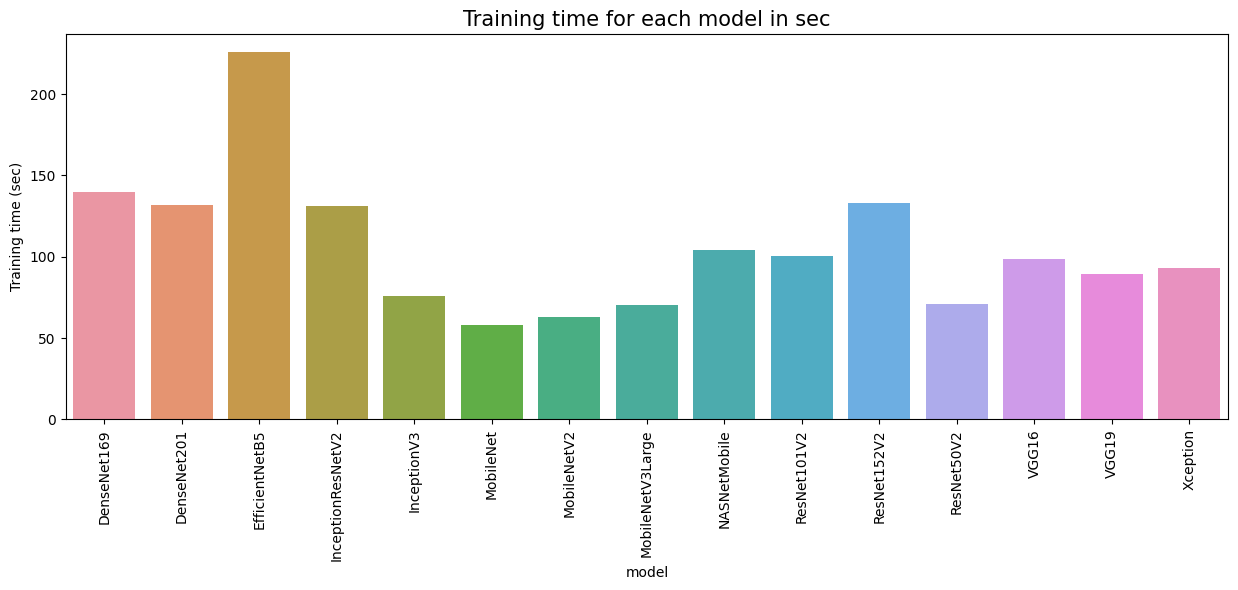

In [15]:
#training time of different pretrained models
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

In [16]:
# Normalize the metrics to rank models fairly
df_results['Train Rank'] = df_results['train_accuracy'].rank(ascending=False)
df_results['Val Rank'] = df_results['val_accuracy'].rank(ascending=False)
df_results['Time Rank'] = df_results['Training time (sec)'].rank(ascending=True)  # Lower time is better

# Compute the final ranking
df_results['Final Rank'] = df_results[['Train Rank', 'Val Rank', 'Time Rank']].mean(axis=1)
df_results.sort_values(by='Final Rank', ascending=True, inplace=True)
df_results.reset_index(drop=True, inplace=True)
df_results

model  train_accuracy  val_accuracy  Training time (sec)  \
0           MobileNet          0.7577        0.7911                58.06   
1         MobileNetV2          0.7577        0.7671                62.96   
2         ResNet101V2          0.7619        0.7842               100.31   
3          ResNet50V2          0.7634        0.7534                71.12   
4        NASNetMobile          0.7558        0.7877               104.21   
5            Xception          0.7524        0.7774                93.15   
6         DenseNet201          0.7584        0.7671               131.58   
7         ResNet152V2          0.7653        0.7568               132.86   
8               VGG16          0.7205        0.7705                98.76   
9         InceptionV3          0.7292        0.7568                75.89   
10        DenseNet169          0.7558        0.7637               139.62   
11   MobileNetV3Large          0.6784        0.6781                70.47   
12              VGG19          0.7118        0.7329                89.28   
13  InceptionResNetV2          0.7323        0.7500               131.42   
14     EfficientNetB5          0.5844        0.6438               225.68   

    Train Rank  Val Rank  Time Rank  Final Rank  
0          5.5       1.0        1.0    2.500000  
1          5.5       6.5        2.0    4.666667  
2          3.0       3.0        9.0    5.000000  
3          2.0      11.0        4.0    5.666667  
4          7.5       2.0       10.0    6.500000  
5          9.0       4.0        7.0    6.666667  
6          4.0       6.5       12.0    7.500000  
7          1.0       9.5       13.0    7.833333  
8         12.0       5.0        8.0    8.333333  
9         11.0       9.5        5.0    8.500000  
10         7.5       8.0       14.0    9.833333  
11        14.0      14.0        3.0   10.333333  
12        13.0      13.0        6.0   10.666667  
13        10.0      12.0       11.0   11.000000  
14        15.0      15.0       15.0   15.000000

In [17]:
# Select the best model
best_model_name = df_results.iloc[0]['model']
best_model_fn = models[best_model_name]['model']

print(f"Best model found: {best_model_name}")

Best model found: MobileNet


In [18]:
# Load the best pretained model based on both training accuracy,validation accuracy and training time
pretrained_model = best_model_fn

pretrained_model.trainable = False

In [19]:
print(pretrained_model.output.shape)

(None, 5)


In [20]:
#Loading the model
inputs = pretrained_model.input


x = pretrained_model.output
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)  # Another dropout for regularization
outputs = Dense(5, activation='softmax')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 202ms/step - accuracy: 0.7151 - loss: 0.8831 - val_accuracy: 0.7911 - val_loss: 0.6597
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.7594 - loss: 0.6521 - val_accuracy: 0.7877 - val_loss: 0.6432
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.7737 - loss: 0.6245 - val_accuracy: 0.7842 - val_loss: 0.6359
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.7557 - loss: 0.6290 - val_accuracy: 0.8014 - val_loss: 0.6259
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.7570 - loss: 0.6605 - val_accuracy: 0.7945 - val_loss: 0.6411
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.7765 - loss: 0.6203 - val_accuracy: 0.7877 - val_loss: 0.6278


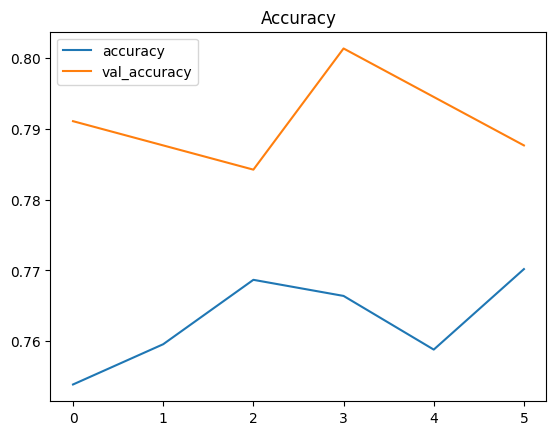

In [21]:
#Accuracy
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

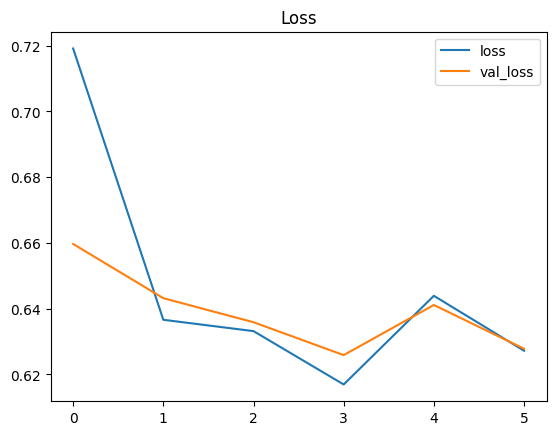

In [22]:
#Loss
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [23]:
#Evaluation
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Accuracy on the test set: {:.2f}%".format(results[1] * 100))

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Loss: 0.64810
Accuracy on the test set: 74.90%


In [24]:
# Predict the label of the test_images
y_pred_probs = model.predict(test_images)
pred = np.argmax(y_pred_probs,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step
The first 5 predictions: ['Moderate', 'No_DR', 'No_DR', 'Moderate', 'No_DR']


In [25]:
#Classification report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

          Mild       0.56      0.36      0.44        67
      Moderate       0.56      0.84      0.67       198
         No_DR       0.93      0.98      0.95       362
Proliferate_DR       0.00      0.00      0.00        63
        Severe       0.38      0.12      0.18        43

      accuracy                           0.75       733
     macro avg       0.49      0.46      0.45       733
  weighted avg       0.68      0.75      0.70       733



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


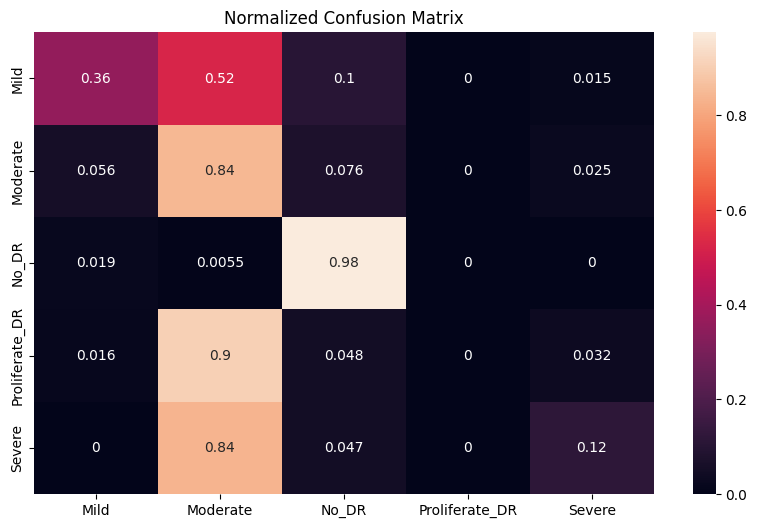

In [26]:
#Normalized Confusion Matrix
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

In [27]:
# Compute metrics
precision = precision_score(y_test, pred, average='weighted')
recall = recall_score(y_test, pred, average='weighted')
f1 = f1_score(y_test, pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.6842375048805255
Recall: 0.7489768076398363
F1 Score: 0.7025260474036504


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
#Evaluation scores
y_true = y_test
y_pred = pred

# Binarize the labels for multiclass classification
lb = LabelBinarizer()
y_true_binarized = lb.fit_transform(y_true)
y_pred_binarized = lb.transform(y_pred)
classes = lb.classes_

# ROC AUC score for each class
roc_auc_scores = {}
for idx, class_name in enumerate(lb.classes_):
    roc_auc_scores[class_name] = roc_auc_score(y_true_binarized[:, idx], y_pred_binarized[:, idx])

print("ROC AUC Scores by Class:")
for class_name, score in roc_auc_scores.items():
    print(f"Class {class_name}: {score:.4f}")

# Overall micro and macro ROC AUC scores
overall_micro_auc = roc_auc_score(y_true_binarized, y_pred_binarized, average='micro')
overall_macro_auc = roc_auc_score(y_true_binarized, y_pred_binarized, average='macro')
print("\n")
print(f"Overall Micro ROC AUC: {overall_micro_auc:.4f}")
print(f"Overall Macro ROC AUC: {overall_macro_auc:.4f}")

ROC AUC Scores by Class:
Class Mild: 0.6648
Class Moderate: 0.8002
Class No_DR: 0.9512
Class Proliferate_DR: 0.5000
Class Severe: 0.5523


Overall Micro ROC AUC: 0.8431
Overall Macro ROC AUC: 0.6937


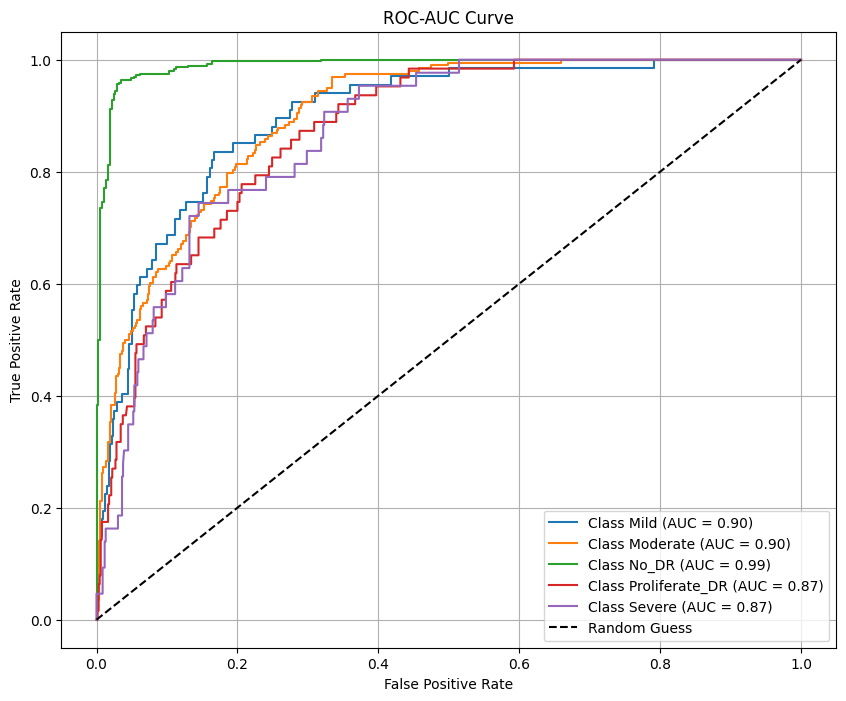

In [29]:
# ROC-AUC Curve for each class
plt.figure(figsize=(10, 8))
for idx, class_name in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, idx], y_pred_probs[:, idx])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.grid()
plt.show()

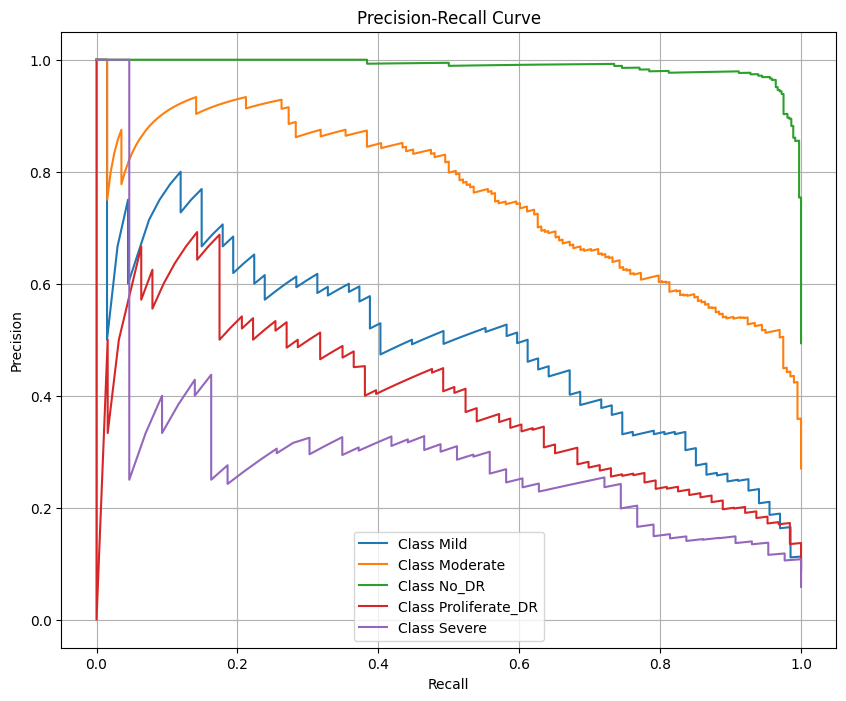

In [30]:
# Precision-Recall Curve for each class
plt.figure(figsize=(10, 8))
for idx, class_name in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_true_binarized[:, idx], y_pred_probs[:, idx])
    plt.plot(recall, precision, label=f"Class {class_name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

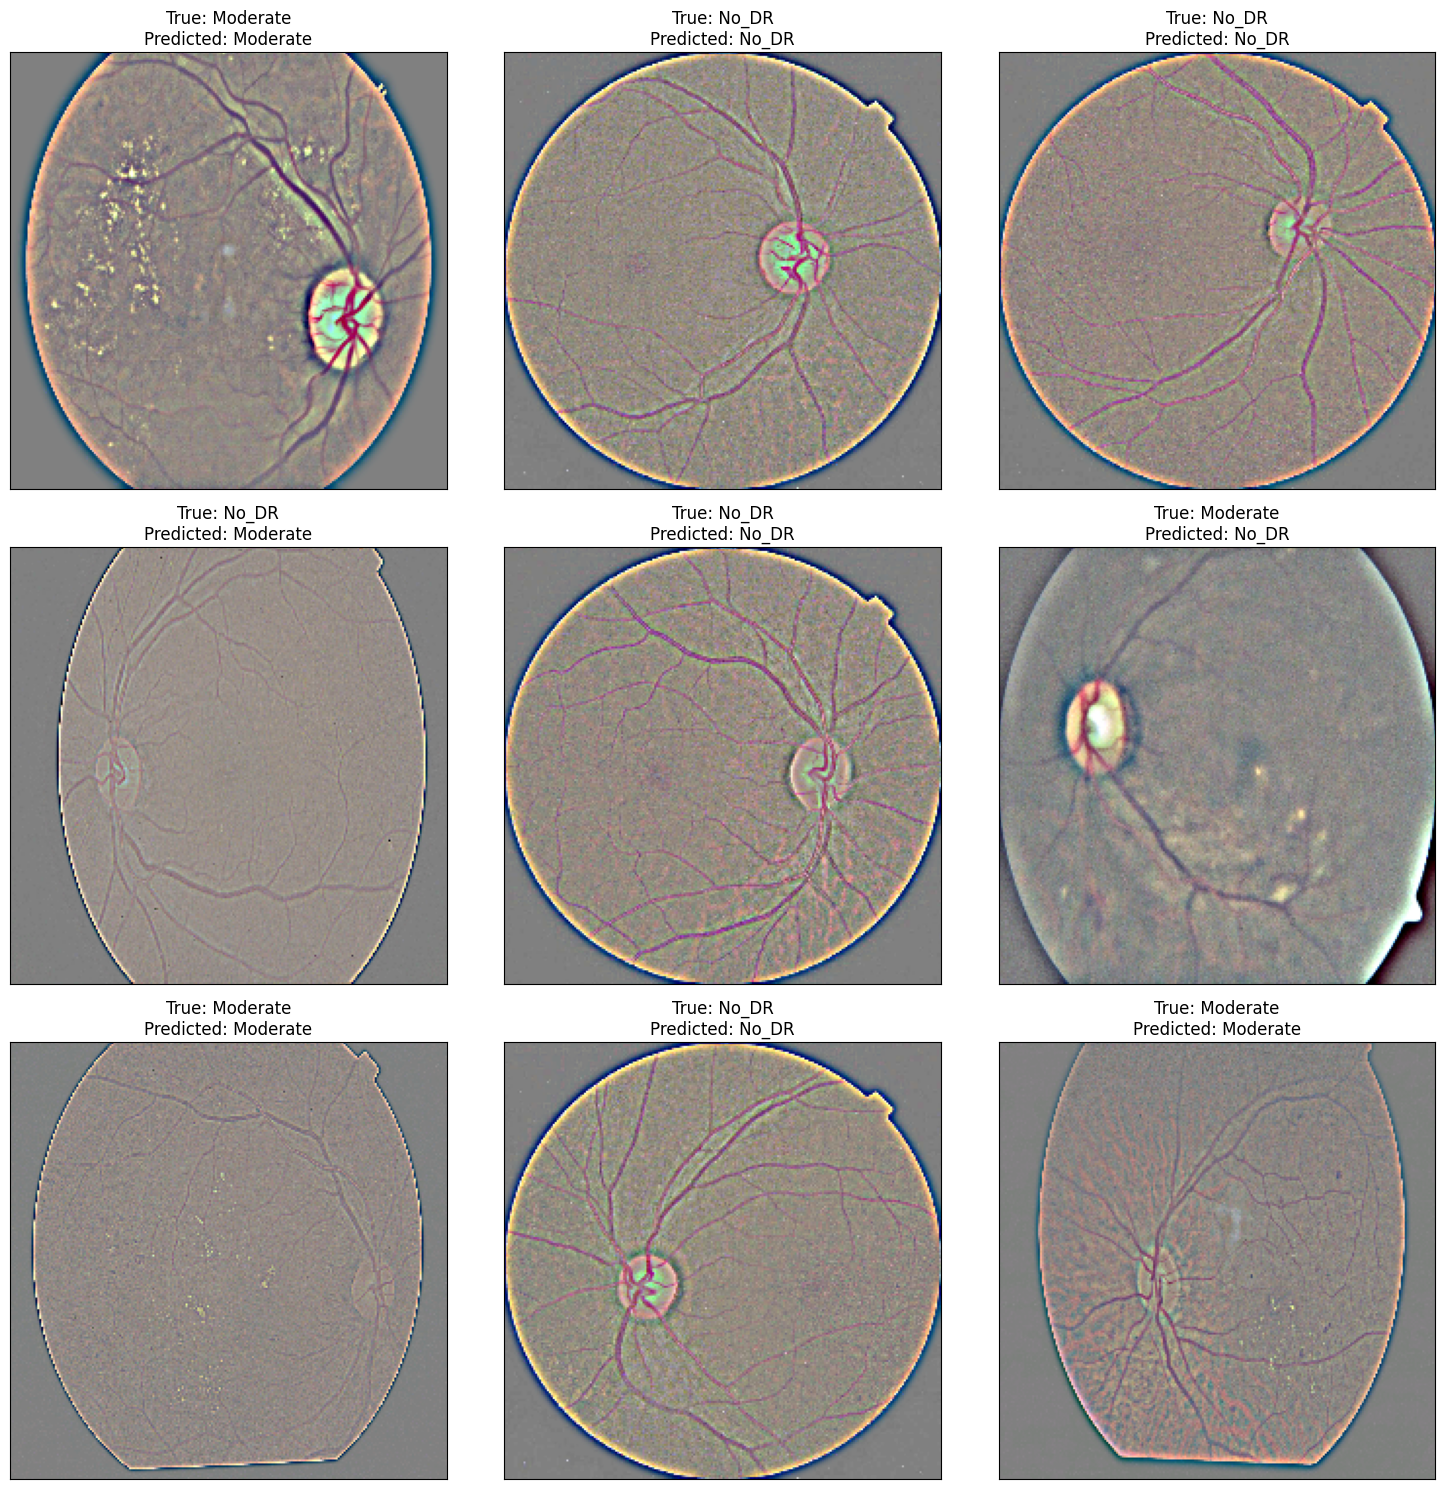

In [31]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [32]:
#model summary
model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 6,406,358 (24.44 MB)

 Trainable params: 533,509 (2.04 MB)

 Non-trainable params: 4,805,829 (18.33 MB)

 Optimizer params: 1,067,020 (4.07 MB)

In [33]:
#save the model
model.save('my_model.h5')

In [34]:
shutil.move('my_model.h5', '/kaggle/working/my_model.h5')

'/kaggle/working/my_model.h5'